### Creating Model 3

* Creating a 3rd model for the NFL Play data. The goal is to predict the play type on 4th down.
* Logistic Regression & Random Forest have been completed, so the next step is a Naive Bayes model, adjusting the smoothing parameters as well as whether the data are sampled relative to their regular distribution or by over and undersampling accordingly.

In [2]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
import nfl_data_py as nfl
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import pandas as pd
from imblearn.combine import SMOTEENN
from DataPipelineFxn import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [ ]:
# get the spark session and data frame
data = GetSparkDF(end_year = 2023, include_undersample = True)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.


/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/07 22:49:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/07 22:49:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
spark, df, test_df, undersample_df = data

In [5]:
# get 2023 season data that was withheld to use as another test set
test_df_2023 = get_2023_season_test_df()

2023 done.


In [6]:
df = df.drop('season')
test_df_2023 = test_df_2023.drop('season')

### Create the Model Pipeline

In [7]:
from pyspark.ml.classification import NaiveBayes

In [8]:
numeric_cols = []
# negative_cols = ['score_differential', 'epa', 'ep', 'temp', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining']
negative_cols = []
for field in df.schema.fields:
    if str(field.dataType) != "StringType()" and (field.name not in negative_cols):
        numeric_cols.append(field.name)
        
numeric_cols.remove("week")

In [9]:
str_col = ["home_team", "away_team", "season_type", "posteam", "posteam_type", "defteam", "side_of_field", "game_half", "week",
        "play_type", 'roof', 'surface']
str_col_output = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", "play_type_idx", 'roof_idx', 'surface_idx']
ohe_col_input = ["home_team_idx", "away_team_idx", "season_type_idx", "posteam_idx", "posteam_type_idx", "defteam_idx", "week_idx",
                  "side_of_field_idx", "game_half_idx", 'roof_idx', 'surface_idx']
ohe_col_vec = ["home_team_vec", "away_team_vec", "season_type_vec", "posteam_vec", "posteam_type_vec", "defteam_vec", "week_vec",
                  "side_of_field_vec", "game_half_ivec", 'roof_vec', 'surface_vec']



# Combine numeric and one-hot encoded columns
va_input_cols = numeric_cols + ohe_col_vec

# process using string indexer first for catgeorical features  
stringIndexer = StringIndexer(inputCols=str_col, outputCols=str_col_output)

# process rating data into second feature
ohe = OneHotEncoder(inputCols=ohe_col_input, outputCols=ohe_col_vec) 

# Assemble features column
va = VectorAssembler(inputCols=va_input_cols, outputCol="features", handleInvalid = "skip")

# process data using maxabs scaler, not necessarily important for trees but consistency
scaler = MinMaxScaler(min = 1, max = 2, inputCol="features", outputCol="scaledFeatures")

# define the model
nb = NaiveBayes(
    featuresCol = 'scaledFeatures', labelCol = 'play_type_idx'
)

# Fit the pipeline
pipeline = Pipeline(stages=[stringIndexer, ohe, va, scaler,  nb])

In [10]:
# hyperparameter search across max depth, bins, and iterations
# paramGrid = ParamGridBuilder()\
#     .addGrid(gbt.maxDepth, np.arange(10, 100, step = 10)) \
#     .addGrid(gbt.maxIter, [20, 50, 100, 200])\
#     .addGrid(gbt.maxBins, np.arange(10, 100, step = 10))\
#     .build()

paramGrid = ParamGridBuilder()\
    .addGrid(nb.smoothing, np.arange(0.05, 1, step = 0.05)) \
    .build()

# build the evaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="play_type_idx",
    metricName="accuracy"
)

# set up the train validation split
tvs = TrainValidationSplit(
    estimator=pipeline,
    evaluator=evaluator,
    estimatorParamMaps=paramGrid,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8
)

In [11]:
# need to replace the empty string in surface
df = df.withColumn(
    'surface',
    F.when(df.surface == '', 'Undefined').otherwise(df.surface)
)

undersample_df = undersample_df.withColumn(
    'surface',
    F.when(undersample_df.surface == '', 'Undefined').otherwise(undersample_df.surface)
)

# fit the model with the hyperparameter search
nb_model = tvs.fit(df)


24/12/07 22:34:33 WARN TaskSetManager: Stage 6 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:36 WARN TaskSetManager: Stage 9 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:39 WARN TaskSetManager: Stage 12 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:43 WARN TaskSetManager: Stage 15 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:44 WARN TaskSetManager: Stage 17 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:45 WARN TaskSetManager: Stage 20 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:46 WARN TaskSetManager: Stage 23 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:48 WARN TaskSetManager: Stage 26 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:49 WARN TaskSetManager: Stage 28 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:49 WARN TaskSetManager: Stage 31 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:50 WARN TaskSetManager: Stage 34 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:52 WARN TaskSetManager: Stage 37 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:53 WARN TaskSetManager: Stage 39 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:53 WARN TaskSetManager: Stage 42 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:54 WARN TaskSetManager: Stage 45 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:56 WARN TaskSetManager: Stage 48 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:56 WARN TaskSetManager: Stage 50 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:57 WARN TaskSetManager: Stage 53 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:58 WARN TaskSetManager: Stage 56 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:34:59 WARN TaskSetManager: Stage 59 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:34:59 WARN TaskSetManager: Stage 61 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:00 WARN TaskSetManager: Stage 64 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:01 WARN TaskSetManager: Stage 67 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:02 WARN TaskSetManager: Stage 70 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:02 WARN TaskSetManager: Stage 72 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:02 WARN TaskSetManager: Stage 75 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:03 WARN TaskSetManager: Stage 78 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:04 WARN TaskSetManager: Stage 81 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:05 WARN TaskSetManager: Stage 83 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:05 WARN TaskSetManager: Stage 86 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:06 WARN TaskSetManager: Stage 89 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:07 WARN TaskSetManager: Stage 92 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:07 WARN TaskSetManager: Stage 94 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:08 WARN TaskSetManager: Stage 97 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:08 WARN TaskSetManager: Stage 100 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:09 WARN TaskSetManager: Stage 103 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:10 WARN TaskSetManager: Stage 105 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:10 WARN TaskSetManager: Stage 108 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:11 WARN TaskSetManager: Stage 111 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:12 WARN TaskSetManager: Stage 114 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:12 WARN TaskSetManager: Stage 116 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:13 WARN TaskSetManager: Stage 119 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:13 WARN TaskSetManager: Stage 122 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:14 WARN TaskSetManager: Stage 125 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:15 WARN TaskSetManager: Stage 127 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:15 WARN TaskSetManager: Stage 130 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:16 WARN TaskSetManager: Stage 133 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:17 WARN TaskSetManager: Stage 136 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:17 WARN TaskSetManager: Stage 138 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:17 WARN TaskSetManager: Stage 141 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:18 WARN TaskSetManager: Stage 144 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:19 WARN TaskSetManager: Stage 147 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:19 WARN TaskSetManager: Stage 149 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:20 WARN TaskSetManager: Stage 152 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:20 WARN TaskSetManager: Stage 155 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:21 WARN TaskSetManager: Stage 158 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:22 WARN TaskSetManager: Stage 160 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:22 WARN TaskSetManager: Stage 163 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:23 WARN TaskSetManager: Stage 166 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:23 WARN TaskSetManager: Stage 169 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:24 WARN TaskSetManager: Stage 171 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:24 WARN TaskSetManager: Stage 174 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:25 WARN TaskSetManager: Stage 177 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:26 WARN TaskSetManager: Stage 180 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:26 WARN TaskSetManager: Stage 182 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:27 WARN TaskSetManager: Stage 185 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:27 WARN TaskSetManager: Stage 188 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:28 WARN TaskSetManager: Stage 191 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:29 WARN TaskSetManager: Stage 193 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:29 WARN TaskSetManager: Stage 196 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:29 WARN TaskSetManager: Stage 199 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:30 WARN TaskSetManager: Stage 202 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:31 WARN TaskSetManager: Stage 204 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:31 WARN TaskSetManager: Stage 207 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:32 WARN TaskSetManager: Stage 210 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:33 WARN TaskSetManager: Stage 213 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:33 WARN TaskSetManager: Stage 215 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:35:34 WARN TaskSetManager: Stage 218 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:35:35 WARN TaskSetManager: Stage 221 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


### Evaluate the Models

#### Non-Undersample

In [12]:
best_model = nb_model.bestModel

# Extract the parameter map of the best model
best_params = best_model.stages[-1].extractParamMap()

# Print the parameters values
print("Tuned Parameters of the Best Model:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

Tuned Parameters of the Best Model:
featuresCol: scaledFeatures
labelCol: play_type_idx
modelType: multinomial
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
smoothing: 0.05


In [13]:
# have to change test df instance
test_df = test_df.withColumn(
    'surface',
    F.when(test_df.surface == '', 'Undefined').otherwise(test_df.surface)
)

test_df_2023 = test_df_2023.withColumn(
    'surface',
    F.when(test_df_2023.surface == '', 'Undefined').otherwise(test_df_2023.surface)
)

prediction = best_model.transform(test_df)
prediction2 = best_model.transform(test_df_2023)

In [14]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

weighted_precision_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedPrecision'
)


weighted_recall_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedRecall'
)

f1_score = f1_evaluator.evaluate(prediction)
accuracy = accuracy_evaluator.evaluate(prediction)
precision_by_label = precision_by_label_eval.evaluate(prediction)
precision = weighted_precision_eval.evaluate(prediction)
recall = weighted_recall_eval.evaluate(prediction)

results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
Weighted Precision: {precision}
Weighted Recall: {recall}
'''

print(results)

24/12/07 22:36:02 WARN TaskSetManager: Stage 224 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:36:02 WARN TaskSetManager: Stage 225 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:36:07 WARN TaskSetManager: Stage 234 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:36:08 WARN TaskSetManager: Stage 235 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:36:11 WARN TaskSetManager: Stage 244 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:36:12 WARN TaskSetManager: Stage 245 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:36:15 WARN TaskSetManager: Stage 254 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:36:15 WARN TaskSetManager: Stage 255 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 22:36:18 WARN TaskSetManager: Stage 264 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.
24/12/07 22:36:18 WARN TaskSetManager: Stage 265 contains a task of very large size (9052 KiB). The maximum recommended task size is 1000 KiB.



F1: 0.5732954336304947
Accuracy: 0.6975705951631015
Precision by Label: 0.6975705951631015
Weighted Precision: 0.4866047352362037
Weighted Recall: 0.6975705951631015



### 2023 Season Test Set Analysis

In [15]:
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='f1'
)

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='accuracy'
)

precision_by_label_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='precisionByLabel'
)

weighted_precision_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedPrecision'
)


weighted_recall_eval = MulticlassClassificationEvaluator(
    labelCol='play_type_idx', predictionCol="prediction",
    metricName='weightedRecall'
)

f1_score = f1_evaluator.evaluate(prediction2)
accuracy = accuracy_evaluator.evaluate(prediction2)
precision_by_label = precision_by_label_eval.evaluate(prediction2)
precision = weighted_precision_eval.evaluate(prediction2)
recall = weighted_recall_eval.evaluate(prediction2)

results = f'''
F1: {f1_score}
Accuracy: {accuracy}
Precision by Label: {precision_by_label}
Weighted Precision: {precision}
Weighted Recall: {recall}
'''

print(results)


F1: 0.3859501676857933
Accuracy: 0.5462485113140135
Precision by Label: 0.5462485113140135
Weighted Precision: 0.29838743611277596
Weighted Recall: 0.5462485113140135



In [16]:
prediction2.groupby(prediction2.prediction).count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2519|
+----------+-----+



In [17]:
prediction2.groupby(prediction2.play_type_idx).count().show()

+-------------+-----+
|play_type_idx|count|
+-------------+-----+
|          0.0| 1376|
|          1.0|  555|
|          4.0|  144|
|          3.0|  167|
|          2.0|  277|
+-------------+-----+



In [18]:
labels = prediction2.select([prediction2.play_type, prediction2.play_type_idx]).distinct().orderBy(prediction2.play_type_idx).select(prediction2.play_type).collect()
labels = [x[0] for x in labels]

In [19]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

#Adapting code from https://www.kaggle.com/code/ashokkumarpalivela/multiclass-classification-using-pyspark for confusion matrix
preds_and_labels = prediction2.select(['prediction','play_type_idx'])\
                              .withColumn('play_type_idx', col('play_type_idx')\
                              .cast(FloatType()))\
                              .orderBy('prediction')
    
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


[[1376.    0.    0.    0.    0.]
 [ 555.    0.    0.    0.    0.]
 [ 277.    0.    0.    0.    0.]
 [ 167.    0.    0.    0.    0.]
 [ 144.    0.    0.    0.    0.]]


Text(95.58159722222221, 0.5, 'Actual')

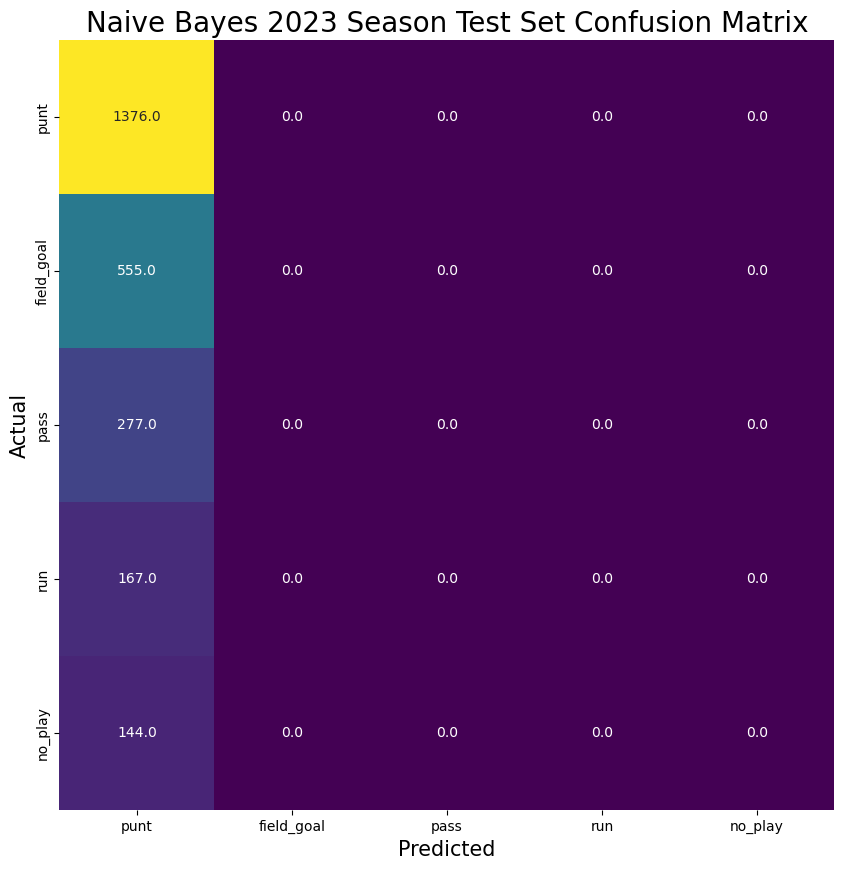

In [20]:
# labels = ["field_goal", "no_play", "pass", "punt", "run"]
_ = plt.figure(figsize=(10, 10))
ax = sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels,
            yticklabels=labels)

plt.title('Naive Bayes 2023 Season Test Set Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
#plt.savefig('naive-bayes-normal-confusion-matrix.png')

### Conclusions

Listed are some general observations
* We achieve a much better performance across all metrics when we sample from the regular distribution rather than applying undersampling and oversampling. The accuracy normally is ~65% compared to ~25% when changing the sampling method. One downside is that the model predicts "punt" much more frequently than any other classes when regular sampling is used. Though this follows the general distribtuion of the training data, it does not account for the other classes well.
* When comapred to the other tested models, the Naive Bayes does neither substantially better or worse. It is in line with the Logistic Regression and Random Forest methods used. 